In [8]:
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator
import topf

%matplotlib inline
mpl.rcParams["axes.labelsize"] = 24
mpl.rcParams["axes.titlesize"] = 24
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 22
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["legend.fontsize"] = 17
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["image.cmap"] = "viridis"

THIS_DIR = os.path.dirname(os.path.abspath("__file__"))
ROOT_DIR = os.path.dirname(os.path.dirname(THIS_DIR))
DATA_DIR = os.path.join(ROOT_DIR,"data")
FIGS_DIR = os.path.join(ROOT_DIR,"reports","figures")

In [2]:
def persistent_filter(data_df, limit):
    filtered_df = data_df.loc[:, data_df.max() > limit].copy()
    topics = [int(column.split("_")[1]) for column in filtered_df.columns]
    for topic in topics:
        topic_arr = filtered_df[f"Topic_{topic}"].to_numpy()
        topic_arr_indexed = np.column_stack((np.arange(topic_arr.shape[0]), topic_arr))
        transformer = topf.PersistenceTransformer()  # prepare transformer
        persistence = transformer.fit_transform(topic_arr_indexed)      # transform data into peaks
        peaks = np.copy(persistence)
        threshold = np.max(topic_arr_indexed[:, 1]) / 2
        peaks[peaks[:, 1] < threshold] = -5
        new_cols = {
            f"persistence_{topic}": persistence[:, 1],
            f"peaks_{topic}": peaks[:, 1],
            f"threshold_{topic}": threshold,
        }
        filtered_df = pd.concat([filtered_df, pd.DataFrame(new_cols, index=filtered_df.index)], axis=1)
    return filtered_df, topics

In [3]:
# EDA
dict={"red":[15,40,49,72, 56, 61, 65, 68, 72, 97,107, 159, 177, 180, 181, 185],
"blue":[0, 12, 35, 39,41, 50, 80, 115, 122, 136, 161, 163, 166],
"magenta":[9, 31, 44, 87, 95, 164, 169, 194],
"green":[19, 81, 117, 134,149]}

data_df = pd.read_parquet(os.path.join(DATA_DIR, "processed", "All_n10.parquet"))
data_df.index = pd.to_datetime(data_df.index)
for key in dict:
    count=0
    for i in dict[key]:
        filter = data_df.loc[data_df["Topic"] == i]
        count += len(filter)
    print(f"{key}: {count}")

dq = data_df.filter(["Topic"])
dq = pd.get_dummies(dq, columns=['Topic'])
dq = dq.resample("D").sum()
for i in range(200):
    if max(dq[f"Topic_{i}"]) <= 25:
        dq = dq.drop(columns=[f"Topic_{i}"])
dq = dq.drop(columns=["Topic_171","Topic_103"])
list = [int(i[6:]) for i in dq.columns]

# drop all entries from data_df with topic number not in list
data_drop = data_df[data_df["Topic"].isin(list)]
print(f"\n{len(data_df)} - {len(data_drop)} = {len(data_df) - len(data_drop)}")

red: 8191
blue: 5856
magenta: 4718
green: 2847

61165 - 20223 = 40942


In [4]:
def peaks_plot(results,topic):
    fig, ax = plt.subplots(figsize=(25, 3.5))
    title=f"Topic {topic}"
    beginning = dt.date(2022, 1, 1)
    end = dt.date(2023,1,1)

    ax.plot(results.index.values, results[f"Topic_{topic}"], color='k', linewidth=1, alpha=1)
    ax.plot(results.index.values, results[f"persistence_{topic}"], color='r', linewidth=1, alpha=0.5)
    ax.scatter(results.index.values, results[f"peaks_{topic}"], color='b', s=20, alpha=1)
    ax.axhline(y=results[f"threshold_{topic}"][0], color='k', linestyle='--', lw=0.8)

    ax.set(title=title, xbound=(beginning, end), ylim=(0))
    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)

    ax.yaxis.set_major_locator(LinearLocator(5))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")
    ticks[-1].set_horizontalalignment("right")

    return fig

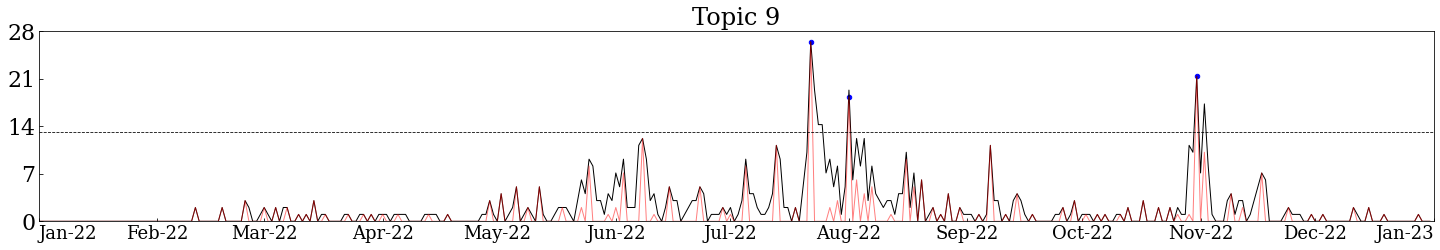

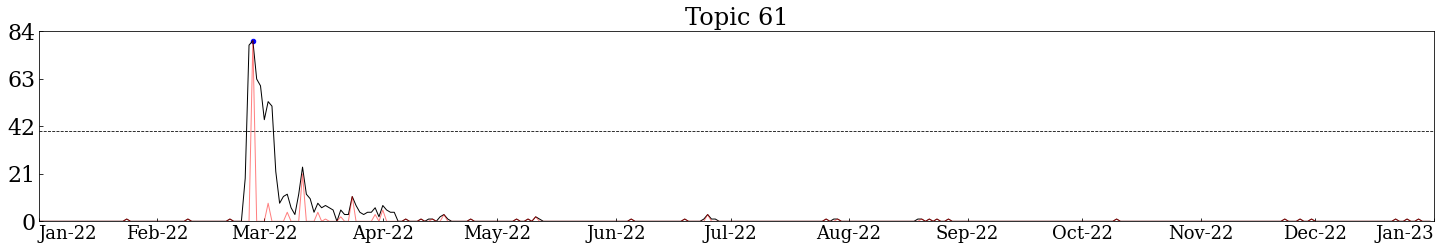

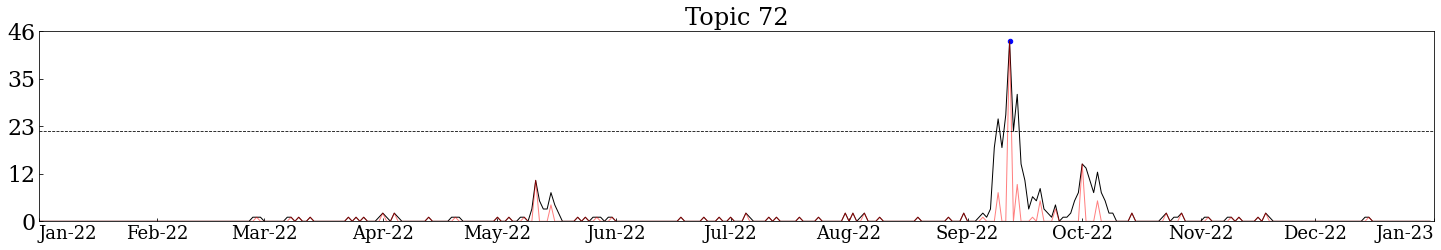

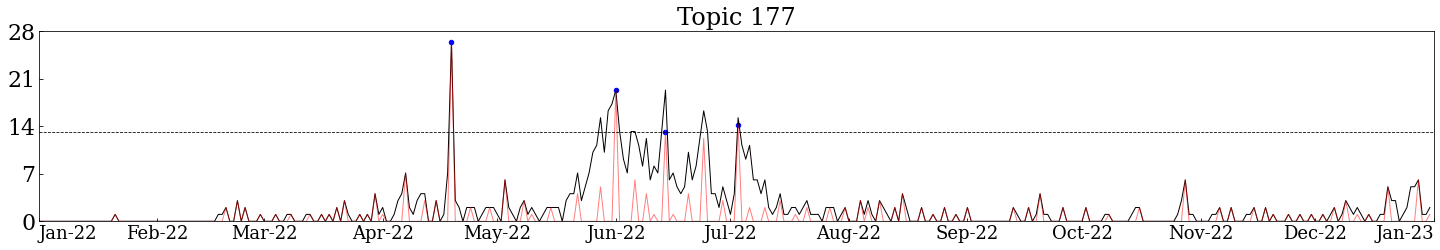

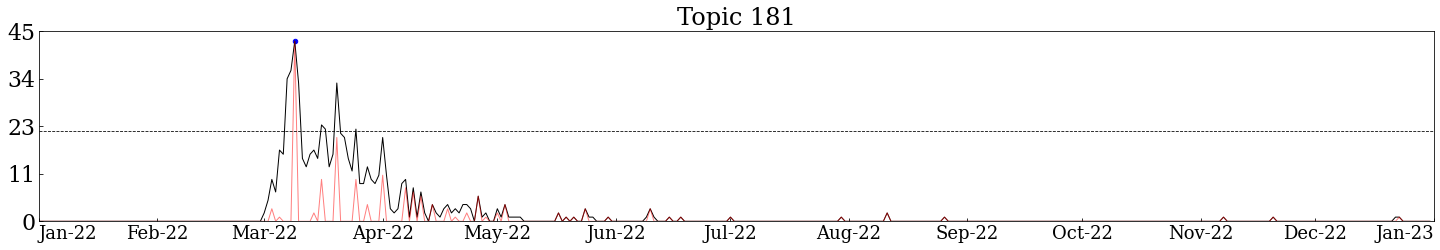

In [7]:
data_df = pd.read_parquet(os.path.join(DATA_DIR, "processed", "All_n10.parquet"))
data_df.index = pd.to_datetime(data_df.index)
data_df = pd.get_dummies(data_df.filter(["Topic"]), columns=['Topic'])
data_df = data_df.resample("D").sum()
results, topics = persistent_filter(data_df,limit=25)
topics = [9,61,72,177,181]
for topic in topics:
    fig = peaks_plot(results, topic)
    #fig.savefig(os.path.join(FIGS_DIR, "peak_detection", f"peak_detection_topic_{topic}.svg"), format="svg", dpi=1000, bbox_inches="tight")
    